In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.utils.data as Data
import torchvision
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
%matplotlib inline

In [2]:
torch.manual_seed(1)

In [3]:
EPOCH = 10
BATCH_SIZE = 32
LR = 0.005
path = '/Users/ruchira/Documents/lvl_4_project/lvl4-hons-project/notebooks'

In [4]:
# X_train = np.loadtxt(path + 'X_train.csv', delimiter=',')
# y_train = np.loadtxt(path + 'y_train.csv', delimiter=',')
# X_test = np.loadtxt(path + 'X_test.csv', delimiter=',')
# y_test = np.loadtxt(path + 'y_test.csv', delimiter=',')

train = np.loadtxt(path + '/train_test_sampled/train.csv', delimiter=',')
test = np.loadtxt(path + '/train_test_sampled/test.csv', delimiter=',')

print(train.shape)
print(test.shape)

(57944, 259)
(54414, 259)


In [5]:
X_train = train[:,:-3]
y_train = train[:,-3]


X_test = test[:,:-3]
y_test = test[:,-3]


print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(57944, 256)
(57944,)
(54414, 256)
(54414,)


In [6]:
train_arr = np.hstack((X_train, y_train.reshape(-1,1)))
print(train_arr.shape)

(57944, 257)


In [7]:
# print(train_arr[:,430].shape)
tensor_Xtrain = torch.from_numpy(X_train)
tensor_ytrain = torch.from_numpy(y_train)

train_data = Data.TensorDataset(tensor_Xtrain, tensor_ytrain)
train_loader = Data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)

In [8]:
# X_train_tensor = torchvision.transforms.ToTensor()(X_train)
# y_train_tensor = torchvision.transforms.ToTensor()(y_train)

In [9]:
# print(transform_train.size())
# print(transform_train[:,:,430].size())


In [10]:
# train_loader = Data.DataLoader(dataset=transform_train, batch_size=BATCH_SIZE, shuffle=True)

In [11]:
print(tensor_Xtrain.size())

torch.Size([57944, 256])


In [12]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(256, 128),
            nn.Tanh(),
            nn.Linear(128, 64),
            nn.Tanh(),
            nn.Linear(64, 12),
            nn.Tanh(),
            nn.Linear(12,3),
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.Tanh(),
            nn.Linear(12, 64),
            nn.Tanh(),
            nn.Linear(64, 128),
            nn.Tanh(),
            nn.Linear(128, 256),
            nn.Sigmoid(), #Compress to a range (0,1)
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [13]:
autoencoder = AutoEncoder()
print(autoencoder)

optimizer = torch.optim.Adam(autoencoder.parameters(), lr=LR)
loss_func = nn.MSELoss()
# view_data = Variable(train_arr[:,430])

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): Tanh()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): Tanh()
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): Tanh()
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): Tanh()
    (6): Linear(in_features=128, out_features=256, bias=True)
    (7): Sigmoid()
  )
)


In [14]:
view_data = tensor_Xtrain[:5].view(-1, 256).type(torch.FloatTensor)/255.


Epoch:  0 | train loss: 0.7048


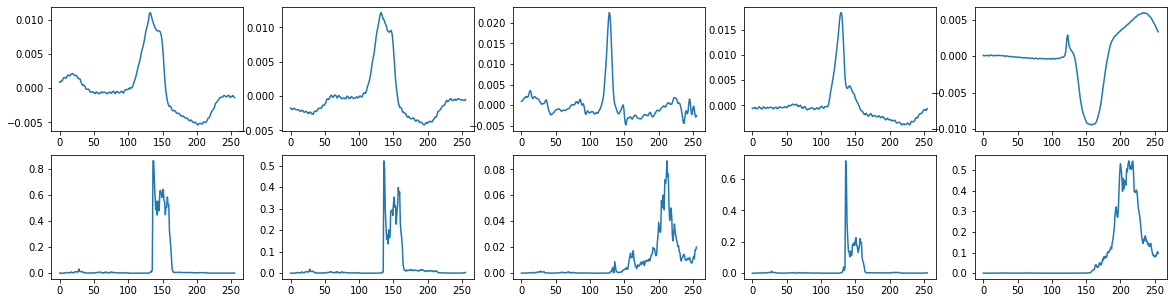

Epoch:  0 | train loss: 0.6868


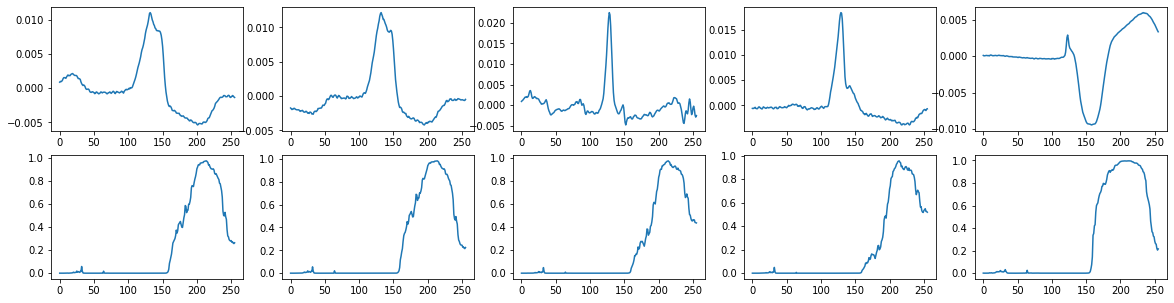

Epoch:  0 | train loss: 0.6809


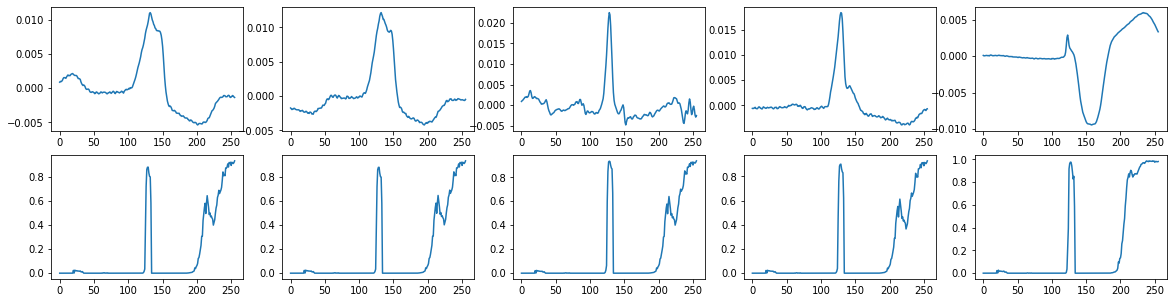

Epoch:  0 | train loss: 0.7094


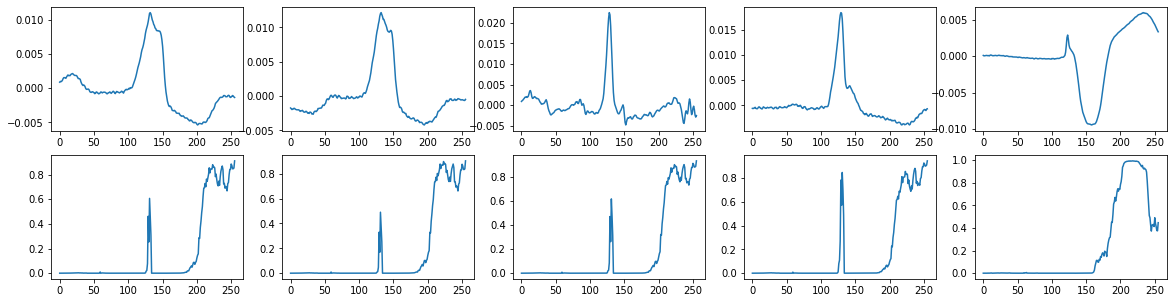

Epoch:  5 | train loss: 0.6898


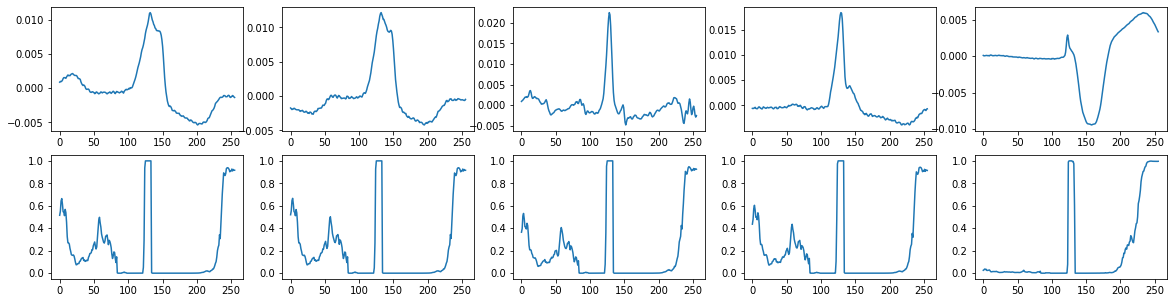

Epoch:  5 | train loss: 0.7198


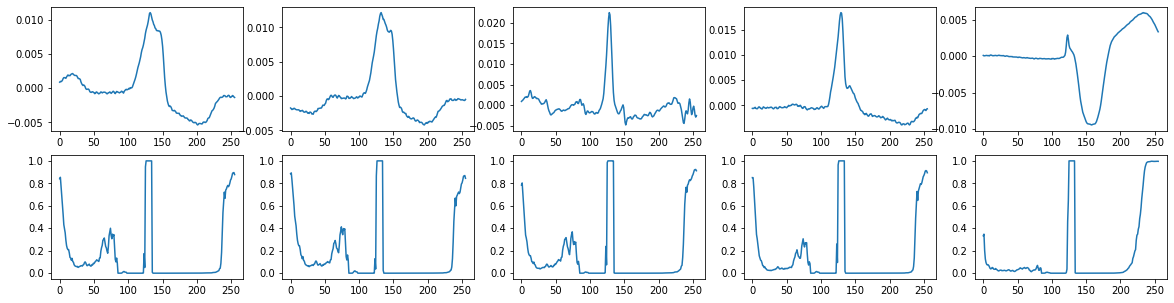

Epoch:  5 | train loss: 0.6899


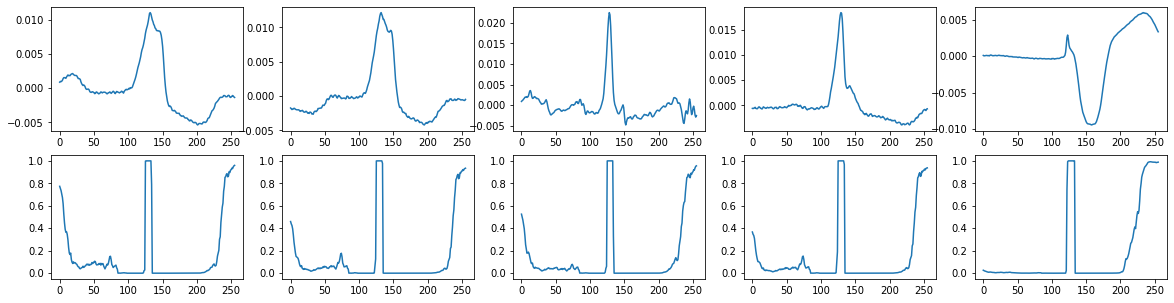

Epoch:  5 | train loss: 0.6789


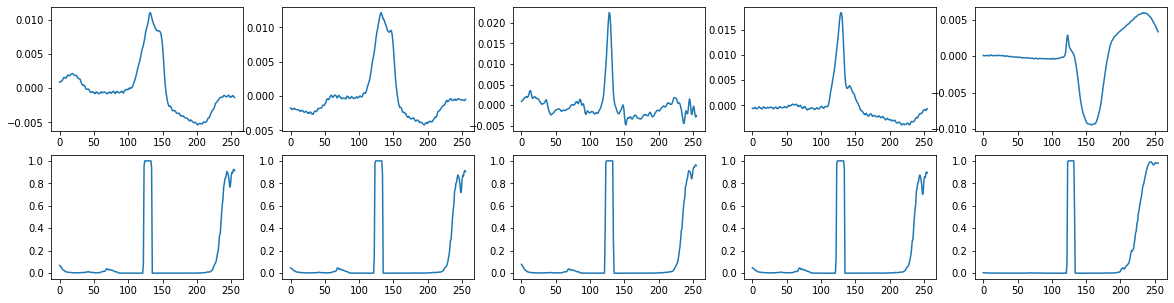

KeyboardInterrupt: 

In [16]:
for epoch in range(EPOCH):
    for step, (x,y) in enumerate(train_loader):
        b_x = x.view(-1, 256).type(torch.FloatTensor)
        b_y = x.view(-1, 256).type(torch.FloatTensor)
        b_label = y
        
        encoded, decoded = autoencoder(b_x)
        loss = loss_func(decoded, b_y) # MSELoss (mean squared error) defined above
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())
            _, decoded_data = autoencoder(view_data)
            f, a = plt.subplots(2, 5, figsize=(20,5))
            
            for i in range(5):
                a[0][i].plot(view_data.data.numpy()[i])
                
            for i in range(5):
                a[1][i].clear()
                a[1][i].plot(decoded_data.data.numpy()[i])
            plt.show();
            

In [ ]:
class VAE(nn.Module):
    def __init__(self, in_channels, latent_dim, 
                 hidden_dims = None, **kwargs):
        super(VAE, self).__init__()
        
        self.latent_dim = latent_dim
        
        modules = []
        if hidden_dims is None:
            hidden_dims = [32,64,128,256,512]
            
        
        # building the encoder
        for h_dim in hidden_dims:
            modules.append(
                nn.Sequential(
                    nn.Conv1d(in_channels, out_channels=h_dim,
                             kernel_size=3, stride=2, padding=1),
                    nn.BatchNorm1d(h_dim),
                    nn.LeakyReLU()
                    ))
            in_channels = h_dim
            
        self.encoder = nn.Sequential(*modules)
        self.fc_mu = nn.Linear(hidden_dims[-1]*4, latent_dim)
        self.fc_var = nn.Linear(hidden_dims[-1]*4, latent_dim)
        
        
        # building the decoder
        modules = []
        self.decoder_input = nn.Linear(latent_dim, hidden_dims[-1]*4)
        hidden_dims.reverse()
        
        for i in range(len(hidden_dims)-1):
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose1d(hidden_dims[i],
                                hidden_dims[i+1],
                                kernel_size=3,
                                stride = 2,
                                padding=1,
                                output_padding=1),
                    nn.BatchNorm1d(hidden_dims[i+1]), 
                    nn.LeakyReLU()
                ))
        
        self.decoder = nn.Sequential(*modules)
        self.final_layer = nn.Sequential(
                            nn.ConvTranspose1d(hidden_dims[-1],
                                              hidden_dims[-1],
                                              kernel_size=3,
                                              stride=2,
                                              padding=1,
                                              output_padding=1),
                            nn.BatchNorm1d(hidden_dims[-1]),
                            nn.LeakyReLU(),
                            nn.Conv1d(hidden_dims[-1], out_channels=3,
                                     kernel_size=3, padding=1),
                            nn.Tanh())

    
    def encode(self, input):
        """
        Encodes the input by passing through the encoder network
        and returns the latent codes.
        :param input: (Tensor) Input tensor to encoder [N x C x H x W]
        :return: (Tensor) List of latent codes
        """
        result = self.encoder(input)
        result = torch.flatten(result, start_dim=1)

        # Split the result into mu and var components
        # of the latent Gaussian distribution
        mu = self.fc_mu(result)
        log_var = self.fc_var(result)

        return [mu, log_var]

    def decode(self, z):
        """
        Maps the given latent codes
        onto the image space.
        :param z: (Tensor) [B x D]
        :return: (Tensor) [B x C x H x W]
        """
        result = self.decoder_input(z)
        result = result.view(-1, 512, 2, 2)
        result = self.decoder(result)
        result = self.final_layer(result)
        return result

    def reparameterize(self, mu, logvar):
        """
        Reparameterization trick to sample from N(mu, var) from
        N(0,1).
        :param mu: (Tensor) Mean of the latent Gaussian [B x D]
        :param logvar: (Tensor) Standard deviation of the latent Gaussian [B x D]
        :return: (Tensor) [B x D]
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def forward(self, input, **kwargs):
        mu, log_var = self.encode(input)
        z = self.reparameterize(mu, log_var)
        return  [self.decode(z), input, mu, log_var]

    def loss_function(self,
                      *args,
                      **kwargs):
        """
        Computes the VAE loss function.
        KL(N(\mu, \sigma), N(0, 1)) = \log \frac{1}{\sigma} + \frac{\sigma^2 + \mu^2}{2} - \frac{1}{2}
        :param args:
        :param kwargs:
        :return:
        """
        recons = args[0]
        input = args[1]
        mu = args[2]
        log_var = args[3]

        kld_weight = kwargs['M_N'] # Account for the minibatch samples from the dataset
        recons_loss =nn.MSELoss(recons, input)


        kld_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - log_var.exp(), dim = 1), dim = 0)

        loss = recons_loss + kld_weight * kld_loss
        return {'loss': loss, 'Reconstruction_Loss':recons_loss, 'KLD':-kld_loss}

    def sample(self,
               num_samples,
               current_device, **kwargs):
        """
        Samples from the latent space and return the corresponding
        image space map.
        :param num_samples: (Int) Number of samples
        :param current_device: (Int) Device to run the model
        :return: (Tensor)
        """
        z = torch.randn(num_samples,
                        self.latent_dim)

        z = z.to(current_device)

        samples = self.decode(z)
        return samples

    def generate(self, x, **kwargs):
        """
        Given an input image x, returns the reconstructed image
        :param x: (Tensor) [B x C x H x W]
        :return: (Tensor) [B x C x H x W]
        """

        return self.forward(x)[0]
            
        

In [ ]:
vae = VAE(1,430)
print(vae)

In [ ]:
for epoch in range(EPOCH):
    for step, (x,y) in enumerate(train_loader):
        b_x = Variable(x.view(-1, 430)).type(torch.FloatTensor)
        b_y = Variable(x.view(-1, 430)).type(torch.FloatTensor)
        b_label = Variable(y)
        
        result= vae(b_x)
#         loss = loss_func(decoded, b_y) #MSELoss (mean squared error) defined above
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
        if step % 500 == 0 and epoch in [0, 5, EPOCH-1]:
            print('Epoch: ', epoch, '| train loss: %.4f' % loss.item())
            result_list = vae(view_data)
            f, a = plt.subplots(2, 5, figsize=(20,5))
            
            for i in range(5):
                a[0][i].plot(view_data.data.numpy()[i])
#                 plt.set_xticks(()); plt.set_yticks(())
                
            for i in range(5):
                a[1][i].clear()
                a[1][i].plot(result_list[0].data.numpy()[i])
#                 a[1][i].set_xticks(()); a[1][i].set_yticks(())
            plt.show();
            